# Coin tosses and MCMC
> MCMC simulations for coin tosses!

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In the [previous post](../em.html), I had discussed regarding the EM algorithm from a programmer's perspective. That blog post sparked an interesting discussion on Twitter which has led to the current post.

> twitter: https://twitter.com/nipun_batra/status/460286604796383233

Thus, I started to investiage how good would MCMC methods perform in comparison to EM. 

#### Problem statement

For a detailed understanding, refer to the previous post. In short, the problem is as follows.

You have two coins - A and B. Both of them have their own biases (probability of obtaining a head (or a tail )). We pick a coin at random and toss it up 10 times. We repeat this procedure 5 times, totaling in 5 observation sets of 10 observations each. However, we are not told which coin was tossed. So, looking at the data and some rough initial guess about the respective coin biases, can we tell something about the likely biases? Let us work it up using PyMC.

#### Customary imports

In [11]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

#### Observations

We use 1 for Heads and 0 for tails.

In [12]:
# 5 observation sets of 10 observations each
observations = np.array([[1,0,0,0,1,1,0,1,0,1],
                         [1,1,1,1,0,1,1,1,1,1],
                         [1,0,1,1,1,1,1,0,1,1],
                         [1,0,1,0,0,0,1,1,0,0],
                         [0,1,1,1,0,1,1,1,0,1]])
observations_flattened = observations.flatten()

#### Number of heads in each obervation set

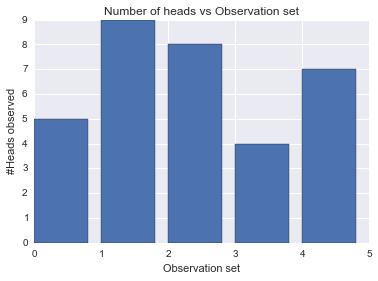

In [13]:
n_heads_array = np.sum(observations, axis=1)
plt.bar(range(len(n_heads_array)),n_heads_array.tolist());
plt.title("Number of heads vs Observation set")
plt.xlabel("Observation set")
plt.ylabel("#Heads observed");

#### Ground truth

The true sequence of coin tosses which was hidden from us. `True` indicated coin A and `False` indicates coin B.

In [14]:
# Ground truth
coins_id = np.array([False,True,True,False,True])

Number of observation sets and number of observations in each set. This allows us to modify data easily (as opposed to hard coding stuff).

In [15]:
n_observation_sets = observations.shape[0]
n_observation_per_set = observations.shape[1]

#### Model for the problem statement

We pick up a simple prior on the bias of coin A. 

$\theta_a$ ~  $\beta(h_a,t_a)$

Similarly, for coin B.

$\theta_b$ ~  $\beta(h_b,t_b)$

For any given observation set, we assign equal probability to it coming from coin A or B.

$coin choice$ ~  DiscreteUniform(0,1)

Thus, if coin choice is known, then the associated bias term is fixed.

$\theta$ = $\theta_a$ if $coin choice$ =1 else $\theta_b$ 

Like, we did in the previous post, we use Binomial distribution with the bias as $\theta$. For each observation set, we calculate the number of heads observed and model it as our observed variable `obs`.

$obs$ = Binomial(n_tosses_per_observation_set, p = $\theta$ )

Let us draw this model using `daft`.

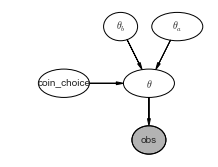

In [18]:
import daft

pgm = daft.PGM([3.6, 2.7], origin=[1, 0.65])
pgm.add_node(daft.Node("theta_a", r"$\theta_a$", 4, 3, aspect=1.8))
pgm.add_node(daft.Node("theta_b", r"$\theta_b$", 3, 3, aspect=1.2))
pgm.add_node(daft.Node("theta", r"$\theta$", 3.5, 2, aspect=1.8))
pgm.add_node(daft.Node("coin_choice", r"coin_choice", 2, 2, aspect=1.8))
pgm.add_node(daft.Node("obs", r"obs", 3.5, 1, aspect=1.2, observed=True))
pgm.add_edge("theta_a", "theta")
pgm.add_edge("theta_b", "theta")
pgm.add_edge("coin_choice", "theta")
pgm.add_edge("theta", "obs")
pgm.render();

The following segment codes the above model.

In [20]:
# Prior on coin A (For now we choose 2 H, 2 T)
theta_a = pm.Beta('theta_a',2,2)

# Prior on coin B (For now we choose 2 H, 2 T)
theta_b = pm.Beta('theta_b',2,2)

# Choosing either A or B 
coin_choice_array = pm.DiscreteUniform('coin_choice',0,1, size = n_observation_sets)

# Creating a theta (theta_a if A is tossed or theta_b if B is tossed)
@pm.deterministic
def theta(theta_a = theta_a, theta_b=theta_b, coin_choice_array=coin_choice_array):
    #print coin_choice_array
    out = np.zeros(n_observation_sets)
    for i, coin_choice in enumerate(coin_choice_array):
        if coin_choice:
            out[i] = theta_a
        else:
            out[i] = theta_b                   
    return out

Let us examine how theta would be related to coin choice and other variables we have defined.

In [22]:
theta_a.value

array(0.46192564399429575)

In [23]:
theta_b.value

array(0.5918506713420255)

In [24]:
coin_choice_array.value

array([1, 1, 0, 0, 1])

In [25]:
theta.value

array([ 0.46192564,  0.46192564,  0.59185067,  0.59185067,  0.46192564])

So, whenever we see coin A, we put it's bias in theta and likewise if we observe coin B. Now, let us create a model for our observations which is binomial as discussed above.

In [26]:
observation_model = pm.Binomial("obs", n=n_observation_per_set, p=theta, value = n_heads_array, observed=True)
model = pm.Model([observation_model, theta_a, theta_b, coin_choice_array])

Let us view a few samples from the `observation_model` which returns the number of heads in 5 sets of 10 tosses. 

In [28]:
observation_model.random()

array([4, 4, 7, 2, 6])

In [29]:
observation_model.random()

array([4, 4, 7, 5, 2])

In [30]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 7.8 sec

Let us have a look at our posteriors for $\theta_a$ and $\theta_b$ 

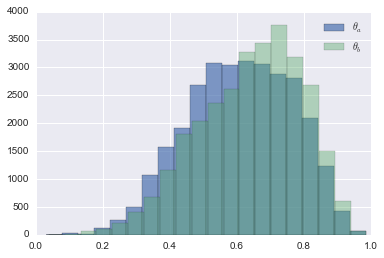

In [32]:
plt.hist(mcmc.trace('theta_a')[:], bins=20,alpha=0.7,label = r"$\theta_a$");
plt.hist(mcmc.trace('theta_b')[:], bins=20,alpha=0.4,label= r"$\theta_b$");
plt.legend();

Looks like both $\theta_a$ and $\theta_b$ peak around the same value. But, wasn't it expected? We gave both of them the same priors.
This was also the case when we initialed EM with same values for both $\theta_a$ and $\theta_b$. So, let us add some informative priors an see how we do.
Like in EM experiment, we knew that one of the coin was more biased than the other. So, let us make that the case and rerun the experiment.

#### More informative priors

In [33]:
# Prior on coin A (more likely to have heads)
theta_a = pm.Beta('theta_a',4,2)

# Prior on coin B (more likely to have tails)
theta_b = pm.Beta('theta_b',2,4)

# Choosing either A or B (for 5 observations)
coin_choice_array = pm.DiscreteUniform('coin_choice',0,1, size = 5)

# Creating a theta (theta_a if A is tossed or theta_b if B is tossed)
@pm.deterministic
def theta(theta_a = theta_a, theta_b=theta_b, coin_choice_array=coin_choice_array):
    #print coin_choice_array
    out = np.zeros(n_observation_sets)
    for i, coin_choice in enumerate(coin_choice_array):
        if coin_choice:
            out[i] = theta_a
        else:
            out[i] = theta_b                   
    return out

In [34]:
observation_model = pm.Binomial("obs", n=10, p=theta, value = n_heads_array, observed=True)
model = pm.Model([observation_model, theta_a, theta_b, coin_choice_array])

In [35]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 8.0 sec

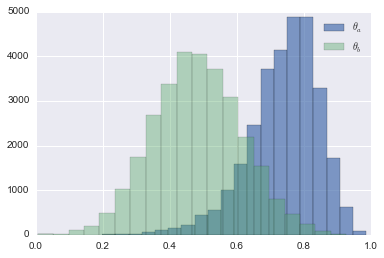

In [36]:
plt.hist(mcmc.trace('theta_a')[:], bins=20,alpha=0.7,label = r"$\theta_a$");
plt.hist(mcmc.trace('theta_b')[:], bins=20,alpha=0.4,label= r"$\theta_b$");
plt.legend();

Quiet a clear distinction now! $\theta_a$ seems to peak around 0.8 and $\theta_b$ around 0.5. This matches our results from EM. However, unlike EM, we have much more than point estimates. 

Feel free to leave your comments and suggestions by.